In [2]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap
from scipy import stats as st
import matplotlib.colors as mcolors

In [4]:
file = pd.read_table('/home/janneae/cns/steps/discretized_9_6bins.features', dtype=str)
survivaldata = pd.read_table('/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt')

In [5]:
lda = LdaModel.load(f'../steps/gensim/lda/lda_t5_f10.model')
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

## Tweaking parameters of LDA analysis

In [10]:
def create_heatmap(model, df):
    topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df

def correlate(cin, survival, val):
    age = []
    tel = []
    lst = []
    hrd = []
    hrd_score = []
    ploidy = []
    wGII = []
    wFLOH = []
    
    for i in range(1, 6):
        age.append(pearsonr(survival[f'{i}'], survival['Age_at_diagnosis'])[val])
        tel.append(pearsonr(cin[f'{i}'], cin['Telomeric.AI'])[val])
        lst.append(pearsonr(cin[f'{i}'], cin['lst'])[val])
        hrd.append(pearsonr(cin[f'{i}'], cin['hrd'])[val])
        hrd_score.append(pearsonr(cin[f'{i}'], cin['hrd_score'])[val])
        ploidy.append(pearsonr(cin[f'{i}'], cin['ploidy'])[val])
        wGII.append(pearsonr(cin[f'{i}'], cin['wGII'])[val])
        wFLOH.append(pearsonr(cin[f'{i}'], cin['wFLOH'])[val])
    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Age_at_diagnosis'] = age
    corr_df['Telomeric.AI'] = tel
    corr_df['LST'] = lst
    corr_df['HRD'] = hrd
    corr_df['HRD_score'] = hrd_score
    corr_df['Ploidy'] = ploidy
    corr_df['wGII'] = wGII
    corr_df['wFLOH'] = wFLOH
    
    corr_df = corr_df.set_index('Signature')
    corr_df = corr_df.transpose()
    
    return corr_df

In [7]:
modelLDA = LdaModel(
    corpus=bow_corpus,
    id2word=dirichlet_dict,
    num_topics=5,
    chunksize=len(bow_corpus),
    passes=10,
    alpha='symmetric',
    eta='auto',
    decay=0.5,
    iterations=5,
    random_state=42)

In [8]:
coherences = CoherenceModel(model=modelLDA, corpus=bow_corpus, texts = listedDf, dictionary=dirichlet_dict, coherence='c_v', topn = 50).get_coherence()
coherences

0.3120759714436182

In [11]:
weights_df = create_heatmap(modelLDA, file)
weights_df = weights_df[weights_df['Chr'] != 23]

combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = survivaldata['age_at_initial_pathologic_diagnosis']
combined_df = combined_df.dropna()

cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ").set_index('sample_id').reindex(index=weights_df['Sample']).reset_index()
combined_cin = weights_df.reset_index()
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna()

corr_df = correlate(combined_cin, combined_df, 0)
pval_df = correlate(combined_cin, combined_df, 1)
corr_df

Signature,1,2,3,4,5
Age_at_diagnosis,0.014910,-0.010098,-0.014611,0.010068,-0.004390
Telomeric.AI,-0.037813,0.394372,-0.344962,-0.110134,0.085178
LST,-0.057808,0.348731,-0.294822,-0.079730,0.073999
HRD,-0.071527,0.296540,-0.277828,-0.039791,0.096383
HRD_score,-0.058195,0.383013,-0.336279,-0.088091,0.091300
Ploidy,0.181452,0.134386,-0.147207,-0.166803,-0.048719
wGII,0.062905,0.303544,-0.334194,-0.120810,0.070268
wFLOH,-0.060455,0.258748,-0.282036,-0.030806,0.131000


In [12]:
psig = 0.001/176000

for i in range(1, 5):
    for j in range(1, 7):
        if pval_df[i][j] > psig:
            corr_df[i][j] = 0
corr_df

Signature,1,2,3,4,5
Age_at_diagnosis,0.014910,-0.010098,-0.014611,0.010068,-0.004390
Telomeric.AI,-0.037813,0.394372,-0.344962,-0.110134,0.085178
LST,-0.057808,0.348731,-0.294822,-0.079730,0.073999
HRD,-0.071527,0.296540,-0.277828,-0.039791,0.096383
HRD_score,-0.058195,0.383013,-0.336279,-0.088091,0.091300
Ploidy,0.181452,0.134386,-0.147207,-0.166803,-0.048719
wGII,0.062905,0.303544,-0.334194,-0.120810,0.070268
wFLOH,-0.060455,0.258748,-0.282036,-0.030806,0.131000


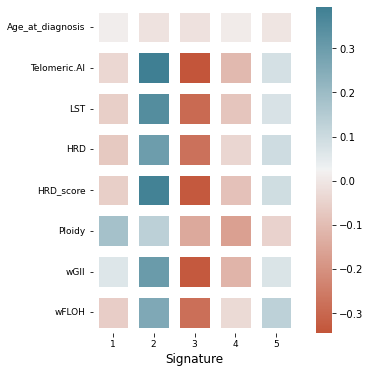

In [13]:
palette = sns.diverging_palette(20, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.savefig('../figures/correlation_matrix_tweak.pdf')